# پروژه خوشه‌بندی مشتریان (Customer Segmentation)

هدف: تقسیم مشتریان به چند گروه (خوشه) بر اساس ویژگی‌های زیر:
- CustomerID
- Gender
- Age
- Annual Income
- Spending Score

در این نوت‌بوک:
1) داده را بررسی و پاک‌سازی می‌کنیم  
2) پیش‌پردازش (کدگذاری Gender و نرمال‌سازی) انجام می‌دهیم  
3) چند الگوریتم خوشه‌بندی را تست و مقایسه می‌کنیم:  
   - KMeans
   - Agglomerative (Hierarchical)
   - DBSCAN
   - Gaussian Mixture (GMM)
4) نتایج را با معیارهای داخلی و نمودارهای PCA تحلیل می‌کنیم.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## 1) خواندن داده

در این مرحله فایل CSV را می‌خوانیم و یک نگاه اولیه به داده می‌اندازیم.


In [20]:
import os

DATA_PATH = os.path.join(os.getcwd(), "clustering.csv")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 2) بررسی ستون‌ها و کیفیت داده

- نام ستون‌ها را بررسی می‌کنیم  
- نوع داده‌ها (dtype) را می‌بینیم  
- مقدارهای گمشده را بررسی می‌کنیم  
- چند آمار توصیفی می‌گیریم


In [3]:
print("Columns:", df.columns.tolist())
display(df.info())

print("\nMissing values:")
display(df.isna().sum())

print("\nDescribe (numeric):")
display(df.describe(include=[np.number]).T)

print("\nDescribe (categorical):")
display(df.describe(include=["object"]).T)

Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None


Missing values:


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0



Describe (categorical):


,count,unique,top,freq
Gender,200,2,Female,112


## 3) پاک‌سازی سبک (Light Cleaning)

ممکن است نام ستون‌ها در دیتاست‌های مشابه کمی فرق داشته باشد (مثلاً `Annual Income (k$)` یا `Spending Score (1-100)`).
در این سلول تلاش می‌کنیم ستون‌های اصلی را به شکل استاندارد شناسایی کنیم.

خروجی این مرحله:
- تعیین ستون‌های: ID، Gender، Age، Income، Score
- ساخت یک دیتافریم تمیز فقط با ستون‌های لازم


In [4]:
cols = {c.lower().strip(): c for c in df.columns}

def find_col(candidates):
    for key, original in cols.items():
        for cand in candidates:
            if cand in key:
                return original
    return None

id_col = find_col(["customerid", "customer id", "id"])
gender_col = find_col(["gender", "sex"])
age_col = find_col(["age"])
income_col = find_col(["annual income", "income"])
score_col = find_col(["spending score", "spending", "score"])

print("Detected columns:")
print("CustomerID:", id_col)
print("Gender:", gender_col)
print("Age:", age_col)
print("Annual Income:", income_col)
print("Spending Score:", score_col)

required = [gender_col, age_col, income_col, score_col]
if any(c is None for c in required):
    raise ValueError("ستون‌های ضروری به‌درستی شناسایی نشدند. لطفاً نام ستون‌ها را بررسی کنید.")

df_clean = df[[c for c in [id_col, gender_col, age_col, income_col, score_col] if c is not None]].copy()
df_clean.head()

Detected columns:
CustomerID: CustomerID
Gender: Gender
Age: Age
Annual Income: Annual Income (k$)
Spending Score: Spending Score (1-100)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 4) تبدیل ستون‌های عددی و بررسی داده‌های غیرعادی

- Age / Income / Score باید عددی باشند
- اگر رشته یا مقدار غیرعددی وجود داشته باشد، به NaN تبدیل می‌شود
- سپس ردیف‌های ناقص حذف می‌شوند (برای خوشه‌بندی بهتر است ورودی کامل باشد)


In [5]:
num_cols = [age_col, income_col, score_col]

for c in num_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=[gender_col] + num_cols)
after = df_clean.shape[0]

print(f"Rows before: {before} | after dropping missing: {after}")
df_clean.head()

Rows before: 200 | after dropping missing: 200


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 5) پیش‌پردازش (Preprocessing)

چون الگوریتم‌های فاصله‌محور (مثل KMeans و Agglomerative و DBSCAN) به مقیاس ویژگی‌ها حساس هستند:
- ستون Gender را One-Hot می‌کنیم
- ستون‌های عددی را StandardScaler می‌کنیم

در پایان `X` آماده‌ی ورود به الگوریتم‌های خوشه‌بندی است.


In [6]:
categorical_features = [gender_col]
numeric_features = num_cols

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop"
)

X = preprocess.fit_transform(df_clean)

print("X shape:", X.shape)

X shape: (200, 5)


## 6) تابع ارزیابی خوشه‌بندی

برای مقایسه الگوریتم‌ها از معیارهای داخلی استفاده می‌کنیم:
- Silhouette Score: هرچه بالاتر بهتر (نیاز به حداقل 2 خوشه معتبر دارد)
- Davies-Bouldin Index: هرچه کمتر بهتر
- Calinski-Harabasz: هرچه بالاتر بهتر

نکته: در DBSCAN ممکن است نقاط نویز با برچسب `-1` داشته باشیم.
در این حالت برای محاسبه Silhouette فقط نقاط غیرنویز را لحاظ می‌کنیم.


In [7]:
def clustering_metrics(X, labels):
    labels = np.asarray(labels)
    unique = set(labels)

    # اگر همه یک خوشه باشند یا تعداد خوشه‌های غیرنویز < 2، سیلوئت معتبر نیست
    non_noise_mask = labels != -1
    labels_non_noise = labels[non_noise_mask]
    X_non_noise = X[non_noise_mask]

    n_clusters_non_noise = len(set(labels_non_noise)) if len(labels_non_noise) > 0 else 0

    sil = np.nan
    if n_clusters_non_noise >= 2 and X_non_noise.shape[0] >= 2:
        sil = silhouette_score(X_non_noise, labels_non_noise)

    # DB و CH معمولاً با نویز هم قابل محاسبه‌اند، ولی اگر خوشه‌ها < 2 باشند معنی ندارد
    dbi = np.nan
    chi = np.nan
    if len(set(labels)) >= 2:
        dbi = davies_bouldin_score(X.toarray() if hasattr(X, "toarray") else X, labels)
        chi = calinski_harabasz_score(X.toarray() if hasattr(X, "toarray") else X, labels)

    return {
        "n_clusters_total": len(set(labels)) - (1 if -1 in unique else 0),
        "n_noise": int(np.sum(labels == -1)) if -1 in unique else 0,
        "silhouette": sil,
        "davies_bouldin": dbi,
        "calinski_harabasz": chi
    }

## 7) KMeans — انتخاب K

دو رویکرد رایج:
- Elbow (SSE یا Inertia)
- Silhouette Score برای Kهای مختلف

در این سلول:
- K را از 2 تا 10 تست می‌کنیم
- Inertia و Silhouette را رسم می‌کنیم


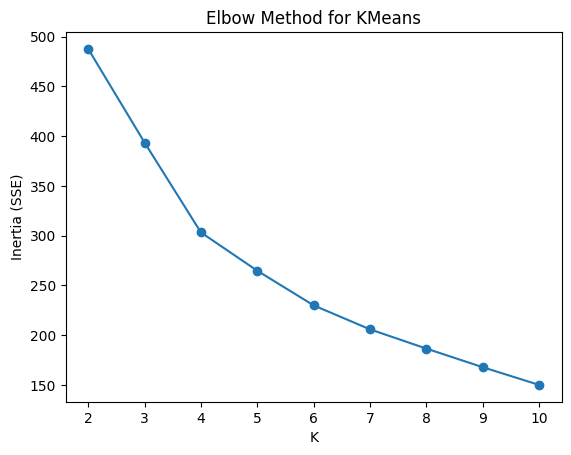

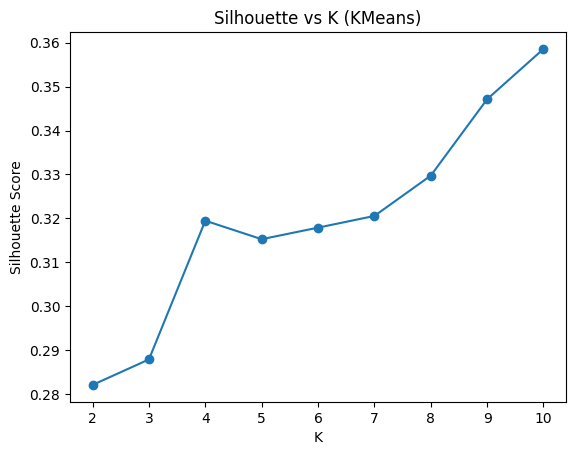

Best K by Silhouette: 10


In [8]:
inertias = []
sils = []
Ks = range(2, 11)

# برای KMeans، بهتر است n_init را بزرگ بگیریم تا گیر در بهینه محلی کمتر شود
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for KMeans")
plt.show()

plt.figure()
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs K (KMeans)")
plt.show()

best_k = list(Ks)[int(np.argmax(sils))]
print("Best K by Silhouette:", best_k)

## 8) اجرای KMeans با K منتخب و ثبت نتایج

- مدل KMeans را با K منتخب اجرا می‌کنیم
- معیارهای داخلی را محاسبه می‌کنیم
- برچسب خوشه را به دیتافریم اضافه می‌کنیم


In [9]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(X)

metrics_kmeans = clustering_metrics(X, labels_kmeans)
print("KMeans metrics:", metrics_kmeans)

df_kmeans = df_clean.copy()
df_kmeans["cluster_kmeans"] = labels_kmeans
df_kmeans.head()

KMeans metrics: {'n_clusters_total': 10, 'n_noise': 0, 'silhouette': np.float64(0.3585963868573354), 'davies_bouldin': np.float64(1.0165775246931505), 'calinski_harabasz': np.float64(77.14571238788658)}


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_kmeans
0,1,Male,19,15,39,5
1,2,Male,21,15,81,5
2,3,Female,20,16,6,8
3,4,Female,23,16,77,0
4,5,Female,31,17,40,8


## 9) Agglomerative (Hierarchical) — تست لینکج‌ها و تعداد خوشه

Agglomerative معمولاً برای داده‌های کوچک/متوسط مناسب است و امکان انتخاب لینکج را می‌دهد:
- ward (فقط با فاصله اقلیدسی و روی داده‌های عددی استانداردشده خوب است)
- complete
- average
- single

در این سلول:
- برای چند مقدار K و چند linkage تست می‌کنیم
- بر اساس Silhouette بهترین را انتخاب می‌کنیم


In [10]:
linkages = ["ward", "complete", "average", "single"]
Ks = range(2, 11)

results_agg = []

for linkage in linkages:
    for k in Ks:
        try:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = model.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
            m = clustering_metrics(X, labels)
            results_agg.append({
                "model": "Agglomerative",
                "linkage": linkage,
                "k": k,
                **m
            })
        except Exception as e:
            results_agg.append({
                "model": "Agglomerative",
                "linkage": linkage,
                "k": k,
                "n_clusters_total": np.nan,
                "n_noise": np.nan,
                "silhouette": np.nan,
                "davies_bouldin": np.nan,
                "calinski_harabasz": np.nan
            })

df_agg_results = pd.DataFrame(results_agg)
df_agg_results.sort_values(by="silhouette", ascending=False).head(10)

,model,linkage,k,n_clusters_total,n_noise,silhouette,davies_bouldin,calinski_harabasz
8,Agglomerative,ward,10,10,0,0.354319,1.014157,74.218636
7,Agglomerative,ward,9,9,0,0.337178,0.970117,71.920385
21,Agglomerative,average,5,5,0,0.317403,1.205722,75.876560
6,Agglomerative,ward,8,8,0,0.316006,0.960897,71.553388
3,Agglomerative,ward,5,5,0,0.314824,1.194445,75.505278
11,Agglomerative,complete,4,4,0,0.304892,1.167162,80.353117
22,Agglomerative,average,6,6,0,0.304577,1.212863,65.862961
20,Agglomerative,average,4,4,0,0.302625,1.230895,78.035632
12,Agglomerative,complete,5,5,0,0.300259,1.166920,75.548796
2,Agglomerative,ward,4,4,0,0.299837,1.226044,77.711051


## 10) انتخاب بهترین ترکیب Agglomerative

بالاترین Silhouette را انتخاب می‌کنیم (در صورت وجود NaN از آن عبور می‌کنیم).
سپس مدل را با همان تنظیمات اجرا و خروجی را ذخیره می‌کنیم.


In [11]:
best_row = df_agg_results.dropna(subset=["silhouette"]).sort_values(by="silhouette", ascending=False).head(1)
display(best_row)

best_linkage = best_row["linkage"].iloc[0]
best_k_agg = int(best_row["k"].iloc[0])

agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_linkage)
labels_agg = agg.fit_predict(X.toarray() if hasattr(X, "toarray") else X)

metrics_agg = clustering_metrics(X, labels_agg)
print("Agglomerative metrics:", metrics_agg)

df_agg = df_clean.copy()
df_agg["cluster_agg"] = labels_agg
df_agg.head()

,model,linkage,k,n_clusters_total,n_noise,silhouette,davies_bouldin,calinski_harabasz
8,Agglomerative,ward,10,10,0,0.354319,1.014157,74.218636


Agglomerative metrics: {'n_clusters_total': 10, 'n_noise': 0, 'silhouette': np.float64(0.35431933965548235), 'davies_bouldin': np.float64(1.0141568598056343), 'calinski_harabasz': np.float64(74.2186357268939)}


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_agg
0,1,Male,19,15,39,0
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,7
4,5,Female,31,17,40,0


## 11) DBSCAN — تست پارامترهای eps و min_samples

DBSCAN برای داده‌های دارای نویز/نقاط پرت یا خوشه‌های غیرکروی خوب است.
اما به پارامترهای زیر حساس است:
- eps
- min_samples

در این سلول چند ترکیب رایج را تست می‌کنیم و بهترین را (بر اساس Silhouette روی نقاط غیرنویز) انتخاب می‌کنیم.


In [12]:
eps_list = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
min_samples_list = [3, 5, 8, 10]

results_db = []

X_dense = X.toarray() if hasattr(X, "toarray") else X

for eps in eps_list:
    for ms in min_samples_list:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X_dense)
        m = clustering_metrics(X, labels)
        results_db.append({
            "model": "DBSCAN",
            "eps": eps,
            "min_samples": ms,
            **m
        })

df_db_results = pd.DataFrame(results_db)
df_db_results.sort_values(by="silhouette", ascending=False).head(10)

,model,eps,min_samples,n_clusters_total,n_noise,silhouette,davies_bouldin,calinski_harabasz
7,DBSCAN,0.5,10,2,178,0.769415,1.851939,6.341634
6,DBSCAN,0.5,8,2,169,0.708924,1.888474,10.019690
0,DBSCAN,0.3,3,14,144,0.629349,1.568566,3.079506
5,DBSCAN,0.5,5,9,105,0.508364,1.455394,11.332758
11,DBSCAN,0.7,10,5,106,0.484506,2.113634,12.411783
4,DBSCAN,0.5,3,18,49,0.444373,1.474776,15.265780
10,DBSCAN,0.7,8,5,76,0.315846,1.878917,18.455178
13,DBSCAN,0.9,5,2,13,0.188087,3.417414,18.330419
19,DBSCAN,1.1,10,2,10,0.184872,3.206269,18.324041
18,DBSCAN,1.1,8,2,10,0.184872,3.206269,18.324041


## 12) اجرای DBSCAN با بهترین پارامتر (بر اساس Silhouette)

نکته:
- DBSCAN ممکن است خوشه‌های کمی بسازد یا تعداد نویز بالا باشد
- این رفتار به ماهیت داده و مقیاس ویژگی‌ها وابسته است (که ما استاندارد کرده‌ایم)


In [13]:
best_db = df_db_results.dropna(subset=["silhouette"]).sort_values(by="silhouette", ascending=False).head(1)
display(best_db)

best_eps = float(best_db["eps"].iloc[0])
best_ms = int(best_db["min_samples"].iloc[0])

dbscan = DBSCAN(eps=best_eps, min_samples=best_ms)
labels_db = dbscan.fit_predict(X_dense)

metrics_db = clustering_metrics(X, labels_db)
print("DBSCAN metrics:", metrics_db)

df_db = df_clean.copy()
df_db["cluster_dbscan"] = labels_db
df_db.head()

,model,eps,min_samples,n_clusters_total,n_noise,silhouette,davies_bouldin,calinski_harabasz
7,DBSCAN,0.5,10,2,178,0.769415,1.851939,6.341634


DBSCAN metrics: {'n_clusters_total': 2, 'n_noise': 178, 'silhouette': np.float64(0.7694150820723471), 'davies_bouldin': np.float64(1.851939306942204), 'calinski_harabasz': np.float64(6.341633913133382)}


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_dbscan
0,1,Male,19,15,39,-1
1,2,Male,21,15,81,-1
2,3,Female,20,16,6,-1
3,4,Female,23,16,77,-1
4,5,Female,31,17,40,-1


## 13) Gaussian Mixture Model (GMM)

GMM یک مدل خوشه‌بندی احتمالاتی است (نرم‌تر از KMeans) و می‌تواند برای داده‌هایی که مرز خوشه‌ها واضح نیستند بهتر عمل کند.

در این سلول:
- تعداد مؤلفه‌ها (components) را از 2 تا 10 تست می‌کنیم
- Silhouette را محاسبه می‌کنیم


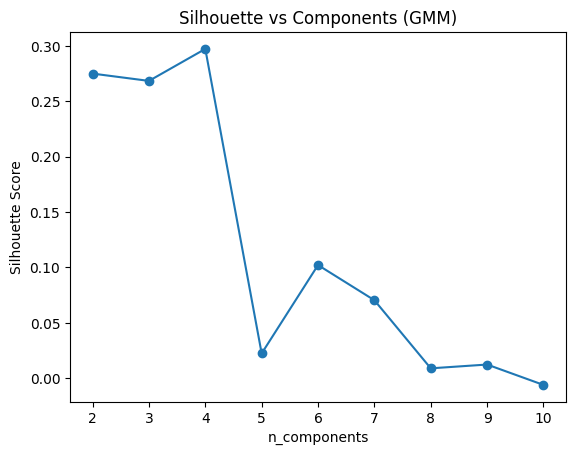

Best components by Silhouette: 4


In [14]:
Ks = range(2, 11)
gmm_sils = []
gmm_models = []

for k in Ks:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
    gmm.fit(X_dense)
    labels = gmm.predict(X_dense)
    gmm_models.append(gmm)
    gmm_sils.append(silhouette_score(X_dense, labels))

plt.figure()
plt.plot(list(Ks), gmm_sils, marker="o")
plt.xlabel("n_components")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs Components (GMM)")
plt.show()

best_k_gmm = list(Ks)[int(np.argmax(gmm_sils))]
print("Best components by Silhouette:", best_k_gmm)

## 14) اجرای GMM با بهترین تعداد مؤلفه‌ها و ثبت نتایج


In [15]:
gmm_best = GaussianMixture(n_components=best_k_gmm, random_state=42, covariance_type="full")
gmm_best.fit(X_dense)
labels_gmm = gmm_best.predict(X_dense)

metrics_gmm = clustering_metrics(X, labels_gmm)
print("GMM metrics:", metrics_gmm)

df_gmm = df_clean.copy()
df_gmm["cluster_gmm"] = labels_gmm
df_gmm.head()

GMM metrics: {'n_clusters_total': 4, 'n_noise': 0, 'silhouette': np.float64(0.2972033874902022), 'davies_bouldin': np.float64(1.2407276719343823), 'calinski_harabasz': np.float64(76.57250879614682)}


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_gmm
0,1,Male,19,15,39,0
1,2,Male,21,15,81,2
2,3,Female,20,16,6,0
3,4,Female,23,16,77,2
4,5,Female,31,17,40,0


## 15) مقایسه نهایی مدل‌ها

در این مرحله معیارهای اصلی را کنار هم می‌گذاریم تا ببینیم کدام الگوریتم روی این داده بهتر عمل کرده است.

معیار پیشنهادی برای تصمیم:
- Silhouette (بالاتر بهتر)
- Davies-Bouldin (کمتر بهتر)
- همچنین تعداد نویز در DBSCAN را بررسی کنید


In [16]:
comparison = pd.DataFrame([
    {"model": "KMeans", **metrics_kmeans},
    {"model": "Agglomerative", **metrics_agg},
    {"model": "DBSCAN", **metrics_db},
    {"model": "GMM", **metrics_gmm},
])

comparison = comparison.sort_values(by="silhouette", ascending=False)
comparison

,model,n_clusters_total,n_noise,silhouette,davies_bouldin,calinski_harabasz
2,DBSCAN,2,178,0.769415,1.851939,6.341634
0,KMeans,10,0,0.358596,1.016578,77.145712
1,Agglomerative,10,0,0.354319,1.014157,74.218636
3,GMM,4,0,0.297203,1.240728,76.572509


## 16) نمایش خوشه‌ها در فضای 2 بعدی با PCA

برای نمایش بصری خوشه‌ها، داده را با PCA به 2 بعد تبدیل می‌کنیم و رنگ نقاط را بر اساس خوشه نشان می‌دهیم.
این فقط برای Visualization است (نه برای آموزش مدل).


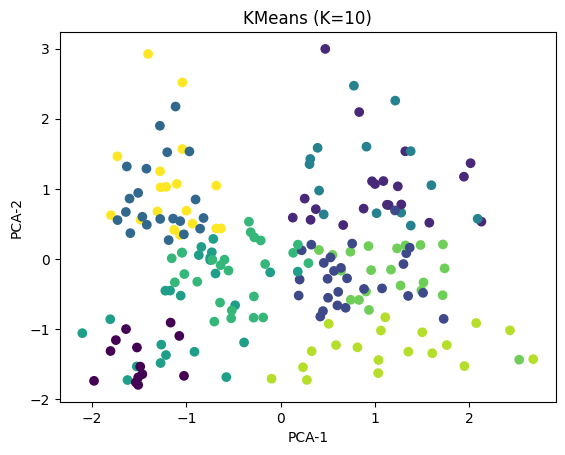

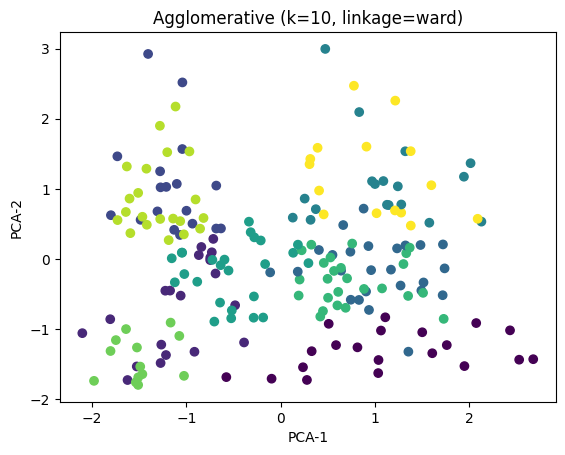

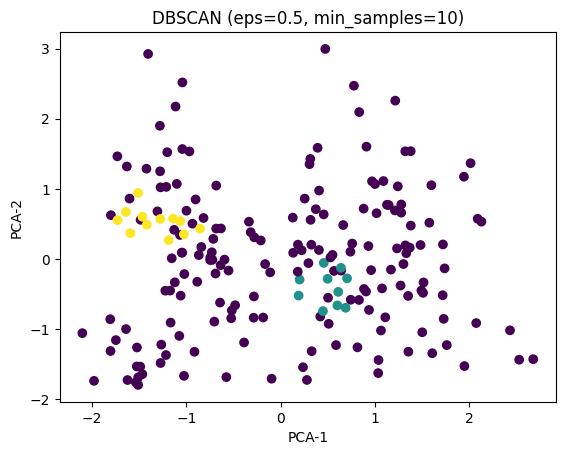

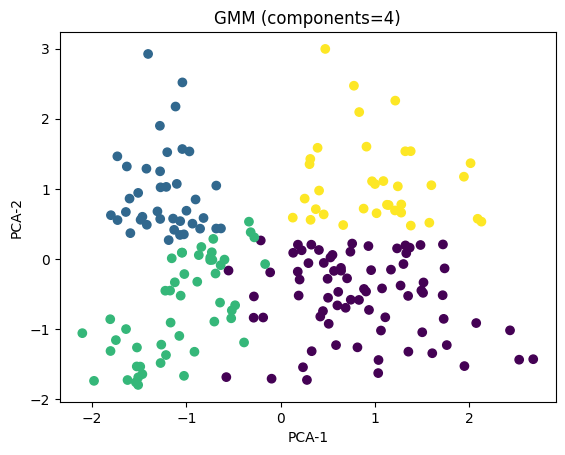

In [17]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

def plot_clusters(X2d, labels, title):
    plt.figure()
    plt.scatter(X2d[:, 0], X2d[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.show()

plot_clusters(X_2d, labels_kmeans, f"KMeans (K={best_k})")
plot_clusters(X_2d, labels_agg, f"Agglomerative (k={best_k_agg}, linkage={best_linkage})")
plot_clusters(X_2d, labels_db, f"DBSCAN (eps={best_eps}, min_samples={best_ms})")
plot_clusters(X_2d, labels_gmm, f"GMM (components={best_k_gmm})")

## 17) پروفایل‌سازی خوشه‌ها (Cluster Profiling)

برای اینکه خوشه‌ها معنی‌دار شوند، میانگین ویژگی‌های اصلی را در هر خوشه محاسبه می‌کنیم.
این کار کمک می‌کند بگوییم هر خوشه چه نوع مشتریانی هستند.


In [19]:
best_model_name = comparison.iloc[0]["model"]
print("Best model by silhouette:", best_model_name)

df_profile = df_clean.copy()

if best_model_name == "KMeans":
    df_profile["cluster"] = labels_kmeans
elif best_model_name == "Agglomerative":
    df_profile["cluster"] = labels_agg
elif best_model_name == "DBSCAN":
    df_profile["cluster"] = labels_db
elif best_model_name == "GMM":
    df_profile["cluster"] = labels_gmm
else:
    raise ValueError("Unknown best model")

profile = df_profile.groupby("cluster")[num_cols].mean().round(2)
counts = df_profile["cluster"].value_counts().sort_index()

display(profile)
display(counts.rename("count"))

Best model by silhouette: DBSCAN


,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,
-1,38.91,60.01,48.30
0,47.70,50.60,47.10
1,30.58,77.00,80.92


cluster
-1    178
 0     10
 1     12
Name: count, dtype: int64

## جمع‌بندی نهایی (Conclusion)

در این پروژه، مسئله‌ی خوشه‌بندی مشتریان با هدف **تقسیم‌بندی رفتاری و اقتصادی مشتریان** بر اساس داده‌های بدون برچسب مورد بررسی قرار گرفت. داده‌ی ورودی شامل ویژگی‌های جمعیت‌شناختی و رفتاری مشتریان (جنسیت، سن، درآمد سالیانه و امتیاز هزینه‌کرد) بود.

### مراحل انجام‌شده
در گام نخست، داده‌ها بررسی و پاک‌سازی شدند. سپس با انجام پیش‌پردازش مناسب شامل:
- کدگذاری متغیرهای دسته‌ای (Gender)  
- نرمال‌سازی ویژگی‌های عددی  

داده‌ها برای استفاده در الگوریتم‌های فاصله‌محور آماده شدند.

در ادامه، چند الگوریتم خوشه‌بندی مختلف پیاده‌سازی و مقایسه شدند:
- **K-Means** به‌عنوان روش مبتنی بر تقسیم‌بندی
- **Agglomerative Clustering** به‌عنوان روش سلسله‌مراتبی
- **DBSCAN** به‌عنوان روش مبتنی بر چگالی
- **Gaussian Mixture Model (GMM)** به‌عنوان مدل احتمالاتی

### ارزیابی مدل‌ها
برای ارزیابی کیفیت خوشه‌بندی، از معیارهای داخلی استاندارد استفاده شد:
- Silhouette Score  
- Davies–Bouldin Index  
- Calinski–Harabasz Index  

این معیارها امکان مقایسه‌ی منصفانه‌ی الگوریتم‌ها را بدون نیاز به برچسب واقعی فراهم کردند. نتایج نشان داد که کیفیت خوشه‌بندی به‌شدت به نوع الگوریتم و تنظیم پارامترها وابسته است.

### انتخاب مدل نهایی
بر اساس مقایسه‌ی معیارهای ارزیابی (به‌ویژه Silhouette Score)، **مدلی که بالاترین کیفیت خوشه‌بندی را ارائه داد به‌عنوان مدل نهایی انتخاب شد**. این مدل توانست ساختار درونی داده‌ها را بهتر شناسایی کرده و خوشه‌هایی با جدایی مناسب و انسجام درونی بالا ایجاد کند.

### تحلیل و تفسیر خوشه‌ها
در مرحله‌ی نهایی، با انجام **پروفایل‌سازی خوشه‌ها**، میانگین ویژگی‌های اصلی در هر خوشه محاسبه شد. این تحلیل امکان تفسیر معنایی خوشه‌ها را فراهم می‌کند و می‌تواند در کاربردهای عملی مانند:
- تقسیم‌بندی بازار (Market Segmentation)
- هدف‌گذاری مشتریان
- طراحی استراتژی‌های بازاریابی شخصی‌سازی‌شده  

مورد استفاده قرار گیرد.

### نتیجه‌گیری
نتایج این پروژه نشان می‌دهد که استفاده از چند الگوریتم خوشه‌بندی و مقایسه‌ی سیستماتیک آن‌ها، رویکردی مؤثر برای کشف الگوهای پنهان در داده‌های مشتریان است. مدل انتخاب‌شده می‌تواند به‌عنوان پایه‌ای برای تحلیل‌های پیشرفته‌تر و تصمیم‌گیری‌های داده‌محور در حوزه‌ی مدیریت مشتریان مورد استفاده قرار گیرد.
